In [148]:
#find files
import pandas as pd
import glob

de = True
eng = False

files = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs DE\*.txt")

In [149]:
startdfs = [0 for x in range(len(files))]

#import txt files as dataframes
for i in range(len(files)):
    df= pd.read_csv(files[i], delimiter = "\t", header = None)
    startdfs[i]=df
print(len(startdfs))
#create a more sorted df
index = []
lang_dict = {}
job_dict = {}
company_dict = {}
descr_dict = {}

for j in range(len(startdfs)):
    
    df = startdfs[j]
    index += [j]
    
    if de:
        lang ="de"
    elif en:
        lang= "en"
    lang_dict[j]= lang;
    
    job = df.iloc[0,0]
    job_dict[j]= job
    
    company = df.iloc[1,0]
    company_dict[j]= company;
    
    descr = df.iloc[2,0]
    for i in range(3,len(df.index)):
        descr = descr + " "+ df.iloc[i,0].strip("◾")
    descr_dict[j] = descr
    
lang_series = pd.Series(lang_dict)
job_series = pd.Series(job_dict)
company_series = pd.Series(company_dict)
descr_series = pd.Series(descr_dict)

df = pd.DataFrame({'job':job_series, 'company':company_series, 'description':descr_series, 'language':lang_series,})

59


In [158]:
#get all descriptions
descrstr = ""
for i in range(len(df)):
    descrstr =descrstr +" "+ df.iloc[i,2]

#let the spacy magic begin ^^
import spacy
from spacy.tokens import Doc
from spacy.lang.de import German

nlp = spacy.load("de_core_news_sm")
doc = nlp(descrstr)

#Matching
from spacy.matcher import Matcher

#get double proper nouns
matcher = Matcher(nlp.vocab)
pattern = [{"POS": "PROPN"}, {"POS": "PROPN"}]
#pattern0 = [{"POS": "PROPN"}]
#matcher.add("pat0", [pattern0])
matcher.add("pat", [pattern])
matches = matcher(doc)

results =  [doc[start:end].text for match_id, start, end in matches]
#put double proper nouns in dict and count them
pnouns = {}
for result in results:
        if result in pnouns:
            pnouns[result] = pnouns[result]+1
        else:
            pnouns[result] = 1

In [159]:
#get single proper nouns (matcher seems to not have the functionallity to exclude the ones already counted in the double ones) 
for i in range(len(doc)):
    token = doc[i]
    addtoken = False
    #first Token has only a right neighbor
    if i == 0:
        rNbor = token.nbor(1)
        if token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
            addtoken = True
    #last Token has only a left neighbor
    elif i == len(doc) -1:
        lNbor = token.nbor(-1)
        if lNbor.pos_ != 'PROPN'and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN':
            addtoken = True
    #default Tokens have a right and a left neighbor
    else:
        rNbor = token.nbor(1)
        lNbor = token.nbor(-1)
        if lNbor.pos_ != 'PROPN' and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
            addtoken = True
            
    if addtoken:
        if token.text in pnouns:
            pnouns[token.text] = pnouns[token.text]+1
        else:
            pnouns[token.text] = 1  
        addtoken = False
            

In [169]:
series = pd.Series(pnouns)
series = series.sort_values(ascending=False)
allnouns_df = pd.DataFrame({'count':series})
print(allnouns_df)
df2 = allnouns_df[:30] 

                          count
Data Science                 30
Machine Learning             26
Data Scientist               21
Python                       17
SQL                          15
...                         ...
SPSS Modeller                 1
Requirements Engineering      1
Key Accounts                  1
REWE Group                    1
Carrypicker                   1

[554 rows x 1 columns]


<AxesSubplot:xlabel='Begriff', ylabel='Anzahl der Nennungen'>

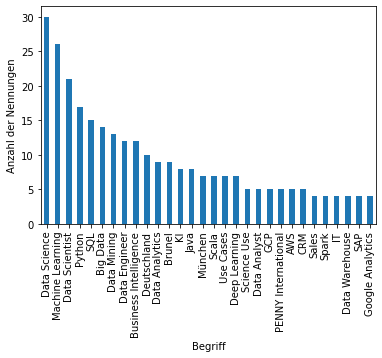

In [170]:
#Plot 
import matplotlib.pyplot as plt
plt.figure()
plt.ylabel('Anzahl der Nennungen')
plt.xlabel('Begriff')
df2['count'].plot(kind='bar')